### Import

For magnetic field calculation:

In [1]:
import numpy as np
import pandas as pd

from math import *
from scipy.special import lpmn
# from scipy.special import legendre

# import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

For field line integration:

In [2]:
from scipy.integrate import odeint

## Input

Point in space (coordinates in planet radius R0):

In [3]:
r = [30, 0, 1e-7]

Jupiter dipole parameters:

In [4]:
R0 = 7.1492e7 #m, Jupiter radius
b_eq = -4.2e5 #nT, field on planet equator

Jupiter magnetodisk parameters:

In [5]:
kmax = 20 # 20, series length
pwr = 2 # 1/r^pwr magnetodisk, pwr=2 for [Alexeev and Belenkaya, 2005]
BDC = 2.5e-9 # 2.5e-9 for [Alexeev and Belenkaya, 2005], magnetic field on edge RD1
RD2 = 18.4 # 18.4 for [Alexeev and Belenkaya, 2005], disk inner edge
RD1 = 92.07 # 92.07 for [Alexeev and Belenkaya, 2005], disk outer edge

Possible correction for theta in case it is extremely close to pi/2:

In [6]:
sign_correction = 1 # 1 or -1

## Calculation

### Dipole field

In [7]:
def dip_field(r, R0, b_eq):
    # Planet dipole field calculation
    # INPUT:
    #   r [R0] - 1D-vector, length=3: (x,y,z)-coordinates of point in space
    #   R0 [m] - scalar: planet radius
    #   b_eq [nT] - scalar: magnetic on planet equator
    # OUTPUT:
    #   B [T] - 1D-vector, length=3: magnetic field
    
    r = R0 * np.array(r)
    M0 = -0.01 * b_eq * R0**3 # planet dipole magnetic moment (SI units, A*m^2)
    Mcoef = 1e-7 * M0;
    # rr = sqrt(r[0] * r[0] + r[1] * r[1] + r[2] * r[2])
    rr = np.linalg.norm(r) # |r|
    Bx = 3 * Mcoef * r[0] * r[2] / rr**5
    By = 3 * Mcoef * r[1] * r[2] / rr**5
    Bz = Mcoef * (3 * r[2] * r[2] - rr**2) / rr**5
    B = np.array([Bx, By, Bz]);
    return B

### Magnetodisk field

Coefficients:

In [8]:
def gen_a2k(kmax):
    # Coefficients a_2k

    a2kArr = np.zeros(kmax + 1);
    a2kArr[0] = 1
    if kmax > 0:
        for j in range(1, kmax + 1):
            a2kArr[j] = -a2kArr[j-1] * (2 * j - 1) / (2 * j)
    return a2kArr

In [9]:
a2kArr = gen_a2k(kmax)

Magnetodisk field calculation:

In [10]:
def uni_signum_series_field(r, pwr, RD1, RD2, BDC, kmax, a2kArr, sign_correction):
    # Magnetodisk field: calculation through series for j~1/r^pwr
    # r - 1D-vector: (x,y,z)-coordinates
    # pwr - scalar: inverse power
    # RD1 - scalar: outer disk edge
    # RD2 - scalar: inner disk edge
    # kmax - scalar: sum number
    # a2kVec - 1D-vector: coefficients
    # sign_correction - scalar: correction for theta in case it is extremely close to pi/2
    
    p = pwr #for brevity
    tau0 = RD2 / RD1
    BMDr = 0 # r-component of magnetodisk field in spherical coordinates
    BMDth = 0 # theta-component of magnetodisk field in spherical coordinates
    # rr = sqrt(r[0] * r[0] + r[1] * r[1] + r[2] * r[2])
    rr = np.linalg.norm(r) # |r|
    th = acos(r[2] / rr)
    tau = rr / RD1
    xi = cos(th)
    eta = sin(th)
    xiArr = np.zeros(2 * kmax + 2)
    xiArr[0] = 1
    xiArr[1] = xi
    for j in range(1, 2 * kmax):
        xiArr[j] = xi * xiArr[j]
    for k in range(kmax + 1):
        if p >= 3 and 2 * k == p - 3:
            specodd = True # odd special case: p=3, 5, 7,...
        else:
            specodd = False
        if p <= 0 and 2 * k == -p:
            speceven = True # even special case: p=0,-2,-4,...
        else:
            speceven = False
        a2k = a2kArr[k]
        allmlegendre = lpmn(1, 2*k+1, xi) # assosiated Legendre functions for all m
        P2kp1 = allmlegendre[0][0][-1] # equiv. alternative: P2kp1 = legendre(2*k+1)(xi)
        Q2kp1 = -allmlegendre[0][1][-1]
        # print(P2kp1)
        # print(Q2kp1)
        if rr <= RD2:
            if speceven:
                BMDr = BMDr - BDC * (2 * k + 1) * a2k * P2kp1 * log(tau0) / tau**p;
                BMDth = BMDth + BDC * a2k * Q2kp1 * log(tau0) / tau**p;
            else:
                BMDr = BMDr + BDC * (2 * k + 1) * a2k * P2kp1 * \
                    tau**(2 * k) * (1 / tau0**(2 * k + p) - 1)/(2 * k + p);
                BMDth = BMDth - BDC * (a2k * Q2kp1 / (2 * k + p)) * \
                    (1 / tau0**(2 * k + p) - 1) * tau**(2 * k)
        elif rr > RD2 and rr < RD1:
            if (not specodd) and (not speceven):
                psingBMDr = (BDC / tau**p) * \
                    (p - 1)**2 * (p - 2)**2 * a2k * P2kp1 * (4 * k + 3) / \
                    ((2 * k + 1) * (2 * k + 2)**2 * (2 * k + p) * (2 * k - p + 3)) # singular part-1
                BMDr = BMDr + psingBMDr + BDC * (2 * k + 1) * a2k * P2kp1 * \
                    (-tau**(2 * k) / (2 * k + p) - \
                    tau0**(2 * k - p + 3) / ((2 * k - p + 3) * tau**(2 * k + 3)))
                if p != 2:
                    psingBMDth = (BDC * (p - 2) / tau**p) * \
                        (p - 1) * (p - 2) * a2k * Q2kp1 * (4 * k + 3) / \
                        ((2 * k + 1) * (2 * k + 2)**2 * (2 * k + p) * (2 * k - p + 3)) # singular part-1
                    BMDth = BMDth + psingBMDth + BDC * (a2k * Q2kp1 / (2 * k + 2)) * \
                        ((2 * k + 2) * tau**(2 * k) / (2 * k + p) - \
                        (2 * k + 1) * tau0**(2 * k - p + 3) / \
                            ((2 * k - p + 3) * tau**(2 * k + 3)))
                else:
                    BMDth = BMDth + \
                        BDC * (a2k * Q2kp1 / (2 * k + 2)) * (tau**(2 * k) - \
                            tau0**(2 * k + 1) / tau**(2 * k + 3))
            elif specodd:
                msingBMDr = (BDC / tau**p) * \
                    a2k * P2kp1 * (4 * k + 3) / (2 * k + 2) * \
                    (1 + (p - 1) * (p - 2)* log(1 + abs(xi))) # minus singular part-0
                msingBMDth = (BDC * (p - 2) / tau**p) * \
                    a2k * Q2kp1 * (4 * k + 3) / ((2 * k + 1) * (2 * k + 2)**2) # minus singular part-0
                BMDr = BMDr - msingBMDr + BDC * (2 * k + 1) * a2k * P2kp1 * \
                    ((log(tau / tau0) + 1 / (2 * k + p)) / tau**p - \
                    tau**(2 * k) / (2 * k + p))
                BMDth = BMDth - msingBMDth + BDC * (a2k * Q2kp1 / (2 * k + 2)) * \
                    (((p - 2) * (log(tau / tau0) + 1 / (2 * k + p)) - 1) / tau**p + \
                    (2 * k + 2) * tau**(2 * k) / (2 * k + p))
            elif speceven:
                msingBMDr = (BDC / tau**p) * \
                    a2k * P2kp1 * (4 * k + 3) / (2 * k + 2) * \
                    (1 + (p - 1) * (p - 2) * log(1 + abs(xi))) # minus singular part-0
                msingBMDth = (BDC * (p - 2) / tau**p) * \
                    a2k * Q2kp1 * (4 * k + 3) / ((2 * k + 1) * (2 * k + 2)**2) # minus singular part-0
                BMDr = BMDr - msingBMDr + BDC * (2 * k + 1) * a2k * P2kp1 * \
                    ((1 / (2 * k - p + 3) - log(tau)) / tau**p - \
                    tau0**(2 * k - p + 3) / ((2 * k - p + 3) * tau**(2 * k + 3)))
                BMDth = BMDth - msingBMDth + BDC * (a2k * Q2kp1 /(2 * k + 2)) * \
                    (((p - 2) * (1 / (2 * k - p + 3) - log(tau)) + 1) / tau**p - \
                    (2 * k + 1) * tau0**(2 * k - p + 3) / \
                        ((2 * k - p + 3) * tau**(2 * k + 3)))
        elif rr >= RD1:
            if specodd:
                BMDr = BMDr - BDC * (2 * k + 1) * a2k * P2kp1 * log(tau0) / tau**p
                BMDth = BMDth - \
                    BDC * (a2k * Q2kp1 / (2 * k + 2)) * (2 * k + 1) * \
                    log(tau0) / tau**p
            else:
                BMDr = BMDr + BDC * (2 * k + 1) * a2k * P2kp1 * \
                    (1 - tau0**(2 * k - p + 3)) / \
                        ((2 * k - p + 3) * tau**(2 * k + 3));
                BMDth = BMDth + BDC * (a2k * Q2kp1 / (2 * k + 2)) * \
                    (2 * k + 1) * (1 - tau0**(2 * k - p + 3)) / \
                        ((2 * k - p + 3) * tau**(2 * k + 3))
    if rr > RD2 and rr < RD1:
        BMDr = BMDr + (BDC / tau**p) * np.sign(xi) * \
            (1 + (p - 1) * (p - 2) * log(1 + abs(xi))) # singular part-0
        if p != 2:
            BMDth = BMDth + (BDC * (p - 2) / tau**p) * \
                (1 - abs(xi)) / eta # singular part-0
    # Magnetic field vector in spherical coordinates
    spherB = np.array([BMDr, BMDth, 0])
    # Correction
    if sign_correction < 0 and th == math.pi / 2:
        spherB = spherB * np.array([-1, 1, 1])
    # Spherical --> Cartesian
    if r[1] >= 0:
        phi = acos(r[0] / sqrt(r[0] * r[0] + r[1] * r[1]))
    else:
        phi = 2 * pi - acos(r[0] / sqrt(r[0] * r[0] + r[1] * r[1]))
    Spher2decMat = np.array([[sin(th) * cos(phi), cos(th) * cos(phi), -sin(phi)],
                [sin(th) * sin(phi), cos(th) * sin(phi), cos(phi)],
                [cos(th), -sin(th), 0]])
    B = np.dot(Spher2decMat, spherB)
    return B

### Total magnetic field

Dipole field + magnetodisk field:

In [11]:
def sum_field(r, pwr, R0, b_eq, RD1, RD2, BDC, kmax, a2kArr, sign_correction):
    B = dip_field(r, R0, b_eq) + uni_signum_series_field(r, pwr, RD1, RD2, BDC, kmax, a2kArr, sign_correction)
    return B

In [12]:
B = sum_field(r, pwr, R0, b_eq, RD1, RD2, BDC, kmax, a2kArr, sign_correction)
print(B)

[ 2.35469026e-08  0.00000000e+00 -8.28562966e-09]


## Magnetic field line integration

Constants:

In [13]:
c = 299792458 # speed of light
abs_e = 1.6021766208 * 1e-19 # abs. value of electron charge
Z = 1 # particle charge q=Z*abs_e
m = 1.6726219e-27 #proton mass

Particle parameters:

In [14]:
K_eV = 1e4
q = Z * abs_e # particle charge
tfin = 9

Simulation accuracy:

In [15]:
stepnum = 1000 # step number, must be integer
accur = 1e-10 # rtol, atol

Momentum and velocity:

In [16]:
p = abs_e * sqrt(K_eV * K_eV + 2 * K_eV * 938.272e6) / 2.99792e8 # |p|, momentum modulus (SI units)
# v = p / m # |v|, classical velocity modulus
v = p / sqrt(m**2 + (p/c)**2) #|v|, relativistic velocity modulus (SI units)

In [17]:
def lor_uni(y, t, q, m, pwr, R0, b_eq, RD1, RD2, BDC, kmax, a2kArr, sign_correction):
    # Lorentz' force: dv/dt=q[v,B]/m
    # y[0] = vx
    # y[1] = vy
    # y[2] = vz
    # y[3] = x
    # y[4] = y
    # y[5] = z
    
    r = y[3:6] / R0
    B = dip_field(r, R0, b_eq) + uni_signum_series_field(r, pwr, RD1, RD2, BDC, kmax,
                                                         a2kArr, sign_correction) # call function
    # print(B)
    dydt = [(q / m) * (y[1] * B[2] - y[2] * B[1]),
            (q / m) * (y[2] * B[0] - y[0] * B[2]),
            (q / m) * (y[0] * B[1] - y[1] * B[0]),
            y[0],
            y[1],
            y[2]]
    return dydt

STUB:

In [18]:
rho_from_Jup = 30
alpha0_grad = 10 # initial pitch-angle
varphi_grad = 0
psi_gradArr = np.arange(0, 259, 30)

In [19]:
varphi = varphi_grad * pi / 180 # azimuthal angle of center
alpha0 = alpha0_grad * pi / 180

In [20]:
B_up_axis = dip_field([rho_from_Jup, 0, 1e-7], R0, b_eq) + uni_signum_series_field([rho_from_Jup, 0, 1e-7], pwr,
                                                                                   RD1, RD2, BDC, kmax, a2kArr,
                                                                                   1) # call function
nBua = np.linalg.norm(B_up_axis)
larm_rad_full = m * v / (R0 * q * nBua) # Larmour radius under central point
larm_rad_real = larm_rad_full * sin(alpha0) # Larmour radius on spiral

z0 = 6 * larm_rad_real

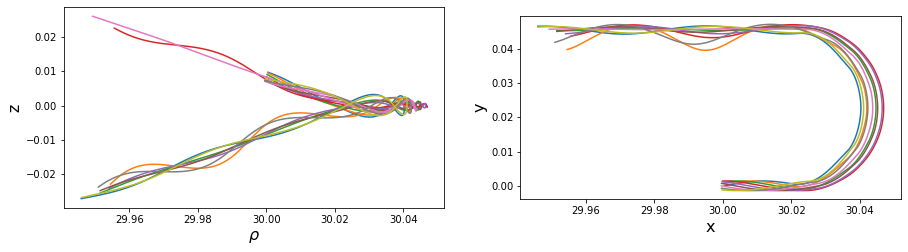

In [21]:
# For trajectories start points putting
r0_cen = [rho_from_Jup * cos(varphi),
          rho_from_Jup * sin(varphi),
          z0] #coordinates of center of particles start point (in R0)
B_start = dip_field(r0_cen, R0, b_eq) + uni_signum_series_field(r0_cen, pwr,
                                                                RD1, RD2, BDC, kmax, a2kArr,
                                                                np.sign(r0_cen[2])) # call function
nBs = np.linalg.norm(B_start) # norm of B_start
beta0 = -asin(B_start[2] / nBs) # angle of inclination for field line, ~20 grad
beta0_grad = (180/pi) * beta0 # field lines inclination (grad)

Matr = np.array([[sin(beta0), 0, -np.sign(r0_cen[2]) * cos(beta0)],
                 [0, 1, 0],
                 [np.sign(r0_cen[2]) * cos(beta0), 0, sin(beta0)]]) # for start points and velocities creation
Matr1 = np.array([[cos(varphi), sin(varphi), 0],
                  [-sin(varphi), cos(varphi), 0],
                  [0, 0, 1]]) # for azimuthal rotation

# I. TRAJECTORIES CALCULATION
psiArr = (pi / 180) * psi_gradArr
psilen = len(psiArr) # number of trajectories

# Figures: initialization
fig = plt.figure(figsize=[15, 9])
# - (rho, z)-graphic
ax_1 = fig.add_subplot(1, 2, 1)
ax_1.set_aspect('equal')
ax_1.set_xlabel(r'$\rho$',
              fontsize = 16
             )
ax_1.set_ylabel('z',
              fontsize = 16
             )
# - (x, y)-graphic
ax_2 = fig.add_subplot(1, 2, 2)
ax_2.set_aspect('equal')
ax_2.set_xlabel('x',
              fontsize = 16
             )
ax_2.set_ylabel('y',
              fontsize = 16
               )

for pnum in range(psilen): # start point number
    psi = psiArr[pnum] # trajectory's psi
    # Put trajectory start point and velocity direction
    startVec = np.array([[larm_rad_real * cos(psi)],
                [larm_rad_real * sin(psi)],
                [0]])
    vVec = v * np.array([-sin(alpha0) * sin(psi),
                         sin(alpha0) * cos(psi),
                         -np.sign(r0_cen[2]) * cos(alpha0)])
    tmp = np.array([[sqrt(r0_cen[0] * r0_cen[0] + r0_cen[1] * r0_cen[1])],
            [0],
            [r0_cen[2]]])            
    r0 = np.dot(np.linalg.inv(Matr1), (tmp + np.dot(Matr, startVec))).T[0]
    vVec_rotated = np.dot(np.linalg.inv(Matr1), np.dot(Matr, vVec))
    r0SI = R0 * r0
    t_span = np.linspace(0, tfin, stepnum)
    y0 = np.hstack([vVec_rotated, r0SI])
    y = odeint(lor_uni, y0, t_span,
               args=(q, m, pwr, R0, b_eq, RD1, RD2, BDC, kmax, a2kArr, sign_correction),
               rtol=accur, atol=accur) / R0
    trajx = y[:, 3]
    trajy = y[:, 4]
    trajz = y[:, 5]
    # print(trajx * trajx + trajy * trajy)
    # print(np.sqrt(np.array(trajx * trajx + trajy * trajy)))
    traj_rho = np.sqrt(trajx * trajx + trajy * trajy)
    ax_1.plot(traj_rho, trajz)
    ax_2.plot(trajx, trajy)